# Assignment 4: Gendered Directions in Embeddings

### References

Bolukbasi et al., (2016) "[*Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings*](https://arxiv.org/pdf/1607.06520.pdf)," arXiv

Joulin et al. (2018) "[*Loss in Translation: Learning Bilingual Word Mapping with a Retrieval Criterion*](https://arxiv.org/abs/1804.07745)," arXiv


In [3]:
import numpy as np
from urllib.request import urlopen
from tqdm import tqdm
import os.path
import time

class AlignedEmbeddingLoader(object):
  """This data loader will download an aligned fasttext embedding given a two letter language code.
  More information ca be found at https://fasttext.cc/docs/en/aligned-vectors.html ."""
  def __init__(self, lang='en'):
    """Data loader"""
    self._dataurl = "https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.%s.align.vec" % lang
    cachefile = "cache_%s.npz" % lang
    if os.path.exists(cachefile):
      print("Loading cached data...", end="")
      t = time.time()
      data = np.load(cachefile)
      self.idx2token_ = list(data['idx2token'])
      self.vectors_ = data['vectors']
      print("done (%isec)" % (time.time()-t), flush=True)
    else:
      with urlopen(self._dataurl) as remote_file:
        get_decoded_line = lambda file: file.readline().decode('utf-8')
        self.n_tokens, self.n_dim = [int(n) for n in get_decoded_line(remote_file).split()]
        self.idx2token_ = list()
        self.vectors_ = np.zeros((self.n_tokens, self.n_dim), dtype=np.float32)
        for n in tqdm(range(self.vectors_.shape[0]), desc="Downloading and parsing vectors"):
          textline = get_decoded_line(remote_file)
          linedata = textline.split(' ')
          self.idx2token_.append(linedata[0])
          self.vectors_[n, :] = np.asarray(linedata[1:], dtype=np.float32)
      np.savez(cachefile, vectors=self.vectors_, idx2token=self.idx2token_)
    self.token2idx_ = {token:i for i, token in enumerate(self.idx2token_)}

loaded_embedding = AlignedEmbeddingLoader('en')

!ls -l

total 5196212
-rw-r--r-- 1 root root 5320910082 Jun  2 15:56 cache_en.npz
drwxr-xr-x 1 root root       4096 May  6 13:44 sample_data


## Your analyzer
This is the analyzer. Your task is to finish this in line with the unit tests, the assignment text specifications, and the paper Bolukbasi (2016).

In [16]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

class EmbeddingAnalyzer(object):
  def __init__(self, embedding):
    self.vectors_ = embedding.vectors_
    self.token2idx_ = embedding.token2idx_
    self.idx2token_ = embedding.idx2token_


  def __len__(self):
    """Gives the number of tokens in the embedding."""
    return self.vectors_.shape[0]


  def __getitem__(self, tokens):
    """Returns the vectors for a token or a list of tokens."""
    if type(tokens) is str:
      idx = self.token2idx_[tokens]
      return self.vectors_[idx]

    elif type(tokens) is list:
      vecs = np.zeros((len(tokens), self.vectors_.shape[1]),
                         dtype=self.vectors_.dtype)
      for i, token in enumerate(tokens):
        idx = self.token2idx_[token]
        vecs[i, :] = self.vectors_[idx]
      return vecs


  def __contains__(self, token):
    """Allows a user query if a tokens is in the embedding."""
    if token in self.token2idx_.keys():
      return True


  def projection(self, direction, vectors):
    """The cosine similarity between a reference direction and a matrix of word vectors.
    direction:
      A vector
    vectors:
      A row matrix with word vectors"""
    cos = []
    d = direction.reshape(1, -1)

    if vectors.ndim == 1:
      v = vectors.reshape(1, -1)
      return cosine_similarity(d, v)[0][0]  #returning the number

    else:
      for v in vectors:  #matrix
        v = v.reshape(1, -1)
        cos.append(cosine_similarity(d, v)) 
      return cos


  def simple_analogy(self, pair, query, k=5):
    """Simple/Classic word analogy as: man - woman = king - queen"""

    v = self.__getitem__(query) - self.__getitem__(pair[0]) + self.__getitem__(pair[1])

    v = v.reshape(1,-1)
    
    distances = euclidean_distances(self.vectors_, v).ravel()

    matches = []

    for idx in np.argsort(distances)[:k]:
      matches.append(self.idx2token_[idx])

    return matches


  def similarity(self, token1, token2):
    """Returns the cosine similarity between two tokens."""

    vec_token1 = self.__getitem__(token1)  #vectorizing token1
    vec_token2 = self.__getitem__(token2)  #vectorizing token2
    
    # reshaping matrices
    vec_token1_reshaped = vec_token1.reshape(1, -1)
    vec_token2_reshaped = vec_token2.reshape(1, -1)

    # calculating cosine_similarity
    cos_similarity = cosine_similarity(vec_token1_reshaped, vec_token2_reshaped)[0][0]

    return cos_similarity


  def analogies(self, analogy_direction, tokens):
    """The more complex word analogy method"""

    lst = []
    analog_dir = analogy_direction.reshape(1, -1)

    for i, token in enumerate(tokens):

      vec_token1 = self.__getitem__(token)
      vec_token1_reshaped = vec_token1.reshape(1, -1)
      max_cos_sim = -5000 #dummy value

      for t in tokens:

        if token != t:
          vec_token2 = self.__getitem__(t) 
          vec_token2_reshaped = vec_token2.reshape(1, -1)

          if euclidean_distances(vec_token1_reshaped - vec_token2_reshaped) <= 1:
              vec_token_resh = vec_token1_reshaped - vec_token2_reshaped
              cos = cosine_similarity(analog_dir + vec_token2_reshaped, vec_token1_reshaped)[0][0]

              if cos > max_cos_sim:
                max_cos_sim = cos
                best_word = t 

          else:
              cos = 0

      lst.append((token, best_word))

    return lst




analyzer = EmbeddingAnalyzer(loaded_embedding)

assert 'man' in analyzer
assert 'woman' in analyzer
assert 'kdjfsfhgkdsjfdh' not in analyzer

assert len(analyzer) > 100000

assert type(analyzer['man']) is np.ndarray
assert np.isclose(np.sum(analyzer['man']-analyzer['man']), 0)

## Word similarity

We should be able to meassure similarity as cosine similarity.

$cos(\overrightarrow{cat}, \overrightarrow{dog}) \geq cos(\overrightarrow{cat}, \overrightarrow{cow})$

In [5]:
assert analyzer.similarity('cat', 'dog') >= analyzer.similarity('cat', 'cow')

## Word analogies

One of the core tasks for showing any semantic properties in an embedding is finding word analogies. We can this of this as word a is to word b, as word c is to word d. Our task is to find word d, knowing a, b, and c.

$\overrightarrow{a} - \overrightarrow{b} \approx \overrightarrow{c} - \overrightarrow{d}$

For gender, this becomes:

$\overrightarrow{man} - \overrightarrow{woman} \approx \overrightarrow{king} - \overrightarrow{x}$

By rearranging we get:

$\overrightarrow{king} - \overrightarrow{man} + \overrightarrow{woman} \approx \overrightarrow{x}$

In [6]:
best_matches = analyzer.simple_analogy(('man', 'woman'), 'king', k=5)

print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

assert 'queen' in analyzer.simple_analogy(('man', 'woman'), 'king', k=5)

Matches (in order of similarity):
1 king
2 queen
3 princess
4 regnant
5 princesses


We can do this for capitols too.

$\overrightarrow{France} - \overrightarrow{Japan} \approx \overrightarrow{Paris} - \overrightarrow{x}$

In [7]:
best_matches = analyzer.simple_analogy(('france', 'japan'), 'paris', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

assert 'tokyo' in analyzer.simple_analogy(('france', 'japan'), 'paris', k=5)

Matches (in order of similarity):
1 tokyo
2 japan
3 osaka
4 kyoto
5 tokyo 


Please try doing this for at least one other famous category (e.g. comparing adjectives).

## Finding the genderedness of professions

Bulokbasi (2016) has a repo for the paper. We can download their data for professions. This allows us to find the genderedness for our embedding and plot against their survey data.

In [8]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/professions.json') as remote_file:
  professions = {title: {'definitional': defi, 'stereotypical': ster} for title, defi, ster in json.load(remote_file)}
print("Loaded %i professions" % len(professions))

Loaded 320 professions


We want to find the projection of vectors for different profession on a gender direction. This can be done by finding the cosine similarity as:

$cos(\overrightarrow{man} - \overrightarrow{woman}, \overrightarrow{butcher})$

$cos(\overrightarrow{man} - \overrightarrow{woman}, \overrightarrow{ballerina})$

The projection should be non-negative as $|cos(\cdot,\cdot)|$. However, by letting the projection method of the anlayzer give us the ccosine similarity, we can see the direction of the projection by looking at its sign.

In [9]:
assert type(analyzer[['man', 'woman', 'butcher']]) is np.ndarray
assert analyzer[['man', 'woman', 'butcher']].shape[0] == 3

assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['butcher']) > 0
assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['ballerina']) < 0

We create a woman-man direction.

In [10]:
direction = analyzer['man']-analyzer['woman']
titles = [title for title in professions.keys() if title in analyzer]
projection = analyzer.projection(direction, analyzer[titles])

The estimation of the gender direction can be improved by using several pairs. Again, we use the data from Bulokbasi (2016).

In [11]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/definitional_pairs.json') as remote_file:
  definitional_pairs = [(m, f) for m, f in json.load(remote_file)]
definitional_pairs

[('woman', 'man'),
 ('girl', 'boy'),
 ('she', 'he'),
 ('mother', 'father'),
 ('daughter', 'son'),
 ('gal', 'guy'),
 ('female', 'male'),
 ('her', 'his'),
 ('herself', 'himself'),
 ('Mary', 'John')]

In [12]:
direction2 = np.zeros(analyzer['man'].shape)
for female, male in definitional_pairs:
  direction2 += analyzer[male.lower()]
  direction2 -= analyzer[female.lower()]

projection2 = analyzer.projection(direction2, analyzer[titles])

We can plot the relation between genderedness in the data and human annotation.

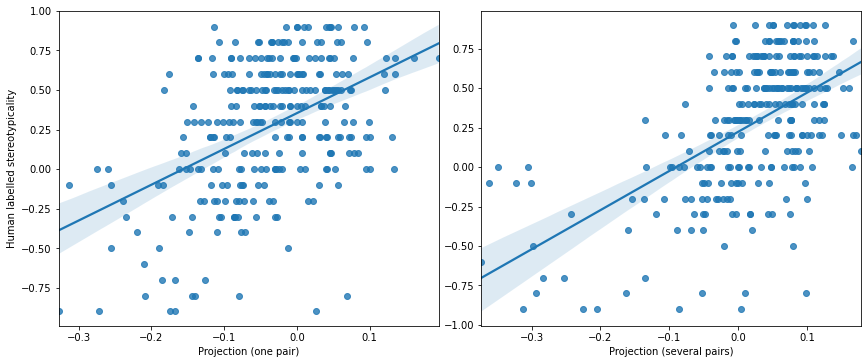

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
stereotypicality = [professions[title]['stereotypical'] for title in titles]
sns.regplot(x=projection, y=stereotypicality, ax=ax[0])
a = sns.regplot(x=projection2, y=stereotypicality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled stereotypicality")
fig.tight_layout(pad=.5)
fig.show()

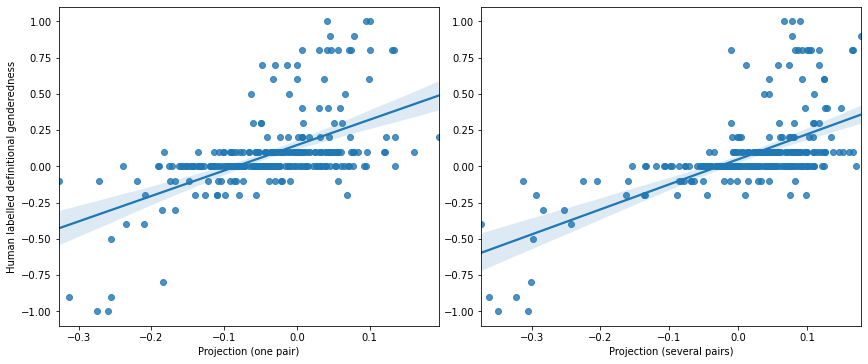

In [14]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
definitionality = [professions[title]['definitional'] for title in titles]
sns.regplot(x=projection, y=definitionality, ax=ax[0])
a = sns.regplot(x=projection2, y=definitionality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled definitional genderedness")
fig.tight_layout(pad=.5)
fig.show()

## More analogies

The paper defines a more advances procedure for analogies as:

$S_{(a,b)}(x, y) = \left\{\begin{matrix}
cos(\overrightarrow{a}-\overrightarrow{b}, \overrightarrow{x}-\overrightarrow{y}) & \parallel \overrightarrow{x}-\overrightarrow{y} \parallel \leq 1\\ 
0 &  \text{otherwise}
\end{matrix}\right.$

This should return a list of tuples with word pairs.

In [17]:
assert len(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == 2 #1
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == list
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])[0]) == tuple

analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])

[('actor', 'actress'), ('actress', 'actor')]

In [18]:
analyzer.analogies(analogy_direction=direction2, tokens=titles)

[('accountant', 'bookkeeper'),
 ('acquaintance', 'housekeeper'),
 ('actor', 'actress'),
 ('actress', 'actor'),
 ('administrator', 'bureaucrat'),
 ('adventurer', 'trader'),
 ('advocate', 'campaigner'),
 ('aide', 'officer'),
 ('alderman', 'councilman'),
 ('alter_ego', 'fashion_designer'),
 ('ambassador', 'envoy'),
 ('analyst', 'commentator'),
 ('anthropologist', 'sociologist'),
 ('archaeologist', 'anthropologist'),
 ('archbishop', 'bishop'),
 ('architect', 'sculptor'),
 ('artist', 'painter'),
 ('artiste', 'performer'),
 ('assassin', 'hitman'),
 ('astronaut', 'scientist'),
 ('astronomer', 'mathematician'),
 ('athlete', 'swimmer'),
 ('attorney', 'solicitor'),
 ('author', 'writer'),
 ('baker', 'butler'),
 ('ballerina', 'dancer'),
 ('ballplayer', 'infielder'),
 ('banker', 'financier'),
 ('barber', 'hairdresser'),
 ('baron', 'socialite'),
 ('barrister', 'solicitor'),
 ('bartender', 'waitress'),
 ('biologist', 'scientist'),
 ('bishop', 'archbishop'),
 ('bodyguard', 'assassin'),
 ('bookkeeper',